Running simulations for trust type: similar_trust


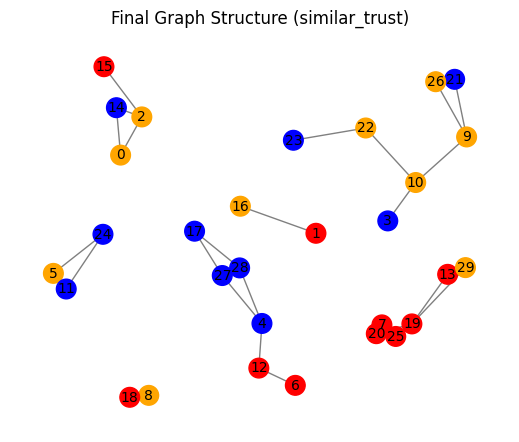

Running simulations for trust type: similar_distrust


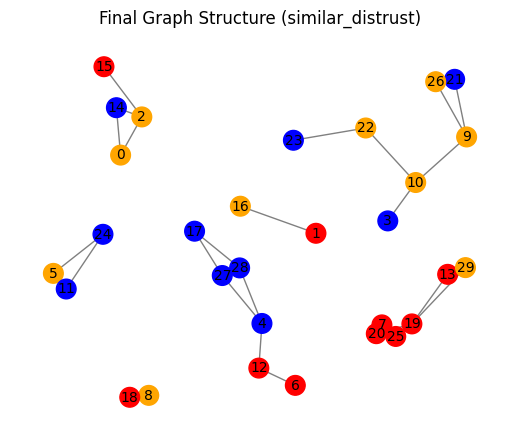

Running simulations for trust type: random


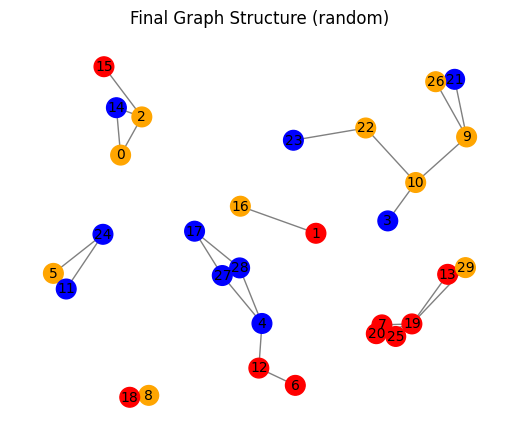

In [ ]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

random.seed(21)

# Function to generate fixed strengths
def generate_agent_strengths(num_agencies):
    """
    Generate fixed strengths for agents to ensure consistency across trust settings.
    """
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    """
    Generate fixed positions for agents.
    """
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# AgencyNetworkModel class
class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold=0.5, trust_type="similar_trust", fixed_positions=None, predefined_strengths=None):
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions
        self.total_benefit = 0

        # Use predefined strengths or generate new ones
        if predefined_strengths is None:
            predefined_strengths = generate_agent_strengths(num_agencies)

        # Initialize agencies
        for i in range(num_agencies):
            social = predefined_strengths[i]["social"]
            tech = predefined_strengths[i]["tech"]
            human = predefined_strengths[i]["human"]
            organizational = predefined_strengths[i]["organizational"]
            strength = predefined_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def compute_benefit(self, i, j):
        """
        Compute the benefit of connecting two agencies based on trust type.
        """
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]

        if self.trust_type == "similar_trust":
            trust = -0.6 * (strength_i - strength_j) ** 2 + 0.2
        elif self.trust_type == "similar_distrust":
            trust = 0.6 * (strength_i - strength_j) ** 2 + 0.2
        elif self.trust_type == "random":
            trust = random.uniform(0, 1)

        # Ensure trust is within valid range
        trust = max(0, min(trust, 1))

        similarity = 1 - abs(strength_i - strength_j)
        alpha, beta = 0.7, 0.3
        benefit = alpha * similarity + beta * trust
        return trust, benefit

    def initialize_random_connections(self):
        """
        Create initial random connections between nearby nodes.
        """
        for i in self.graph.nodes:
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j and self.compute_distance(i, j) <= self.distance_threshold
            ]
            if potential_nodes:
                j = random.choice(potential_nodes)
                trust, benefit = self.compute_benefit(i, j)
                self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                self.total_benefit += benefit

    def step(self):
        """
        Simulate one step of the model.
        Agencies adjust their connections to maximize benefit.
        """
        changes_made = False
        new_total_benefit = 0

        for i in self.graph.nodes:
            neighbors = list(self.graph.neighbors(i))
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j
                and self.compute_distance(i, j) <= self.distance_threshold
                and j not in neighbors
            ]
            existing_benefits = {
                neighbor: self.graph[i][neighbor]["benefit"] for neighbor in neighbors
            }
            for j in potential_nodes:
                trust, benefit = self.compute_benefit(i, j)
                if neighbors:
                    weakest_neighbor = min(existing_benefits, key=existing_benefits.get)
                    weakest_benefit = existing_benefits[weakest_neighbor]
                    if benefit > weakest_benefit:
                        self.graph.remove_edge(i, weakest_neighbor)
                        self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                        changes_made = True
                        break
                else:
                    self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                    changes_made = True
                    break

            for neighbor in self.graph.neighbors(i):
                new_total_benefit += self.graph[i][neighbor]["benefit"]

        if new_total_benefit > self.total_benefit:
            self.total_benefit = new_total_benefit
            return True
        return changes_made

    def visualize_graph(self, title="Graph Structure"):
      """
      Visualize the graph structure using NetworkX.
      Nodes are colored based on their strength levels without using a colorbar.
      """
      plt.figure(figsize=(5, 4))

      # Categorize nodes into three strength groups
      strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
      low_threshold = np.percentile(strengths, 33)
      high_threshold = np.percentile(strengths, 66)

      node_colors = []
      for i in self.graph.nodes:
          strength = self.graph.nodes[i]["strength"]
          if strength <= low_threshold:
              node_colors.append("blue")  # Low strength
          elif strength <= high_threshold:
              node_colors.append("orange")  # Medium strength
          else:
              node_colors.append("red")  # High strength

      # Draw the graph with colored nodes
      pos = self.fixed_positions
      nx.draw(
          self.graph,
          pos,
          with_labels=True,
          node_size=200,
          node_color=node_colors,
          edge_color="gray",
          font_size=10,
      )

      # Add a custom legend
      legend_labels = {
          "Low Strength": "blue",
          "Medium Strength": "orange",
          "High Strength": "red",
      }
      for label, color in legend_labels.items():
          plt.scatter([], [], c=color, label=label, s=100)
      #plt.legend(title="Strength Levels", loc="upper right")

      plt.title(title)
      plt.show()

# Main Execution
if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.2
    max_iterations = 30
    trust_types = ["similar_trust", "similar_distrust", "random"]
    num_simulations = 100

    fixed_positions = generate_fixed_positions(num_agencies)
    predefined_strengths = generate_agent_strengths(num_agencies)

    results = {trust_type: {"strength_diff": [], "trust": []} for trust_type in trust_types}

    for trust_type in trust_types:
        print(f"Running simulations for trust type: {trust_type}")
        for sim in range(num_simulations):
            model = AgencyNetworkModel(
                num_agencies=num_agencies,
                distance_threshold=distance_threshold,
                trust_type=trust_type,
                fixed_positions=fixed_positions,
                predefined_strengths=predefined_strengths
            )
            model.initialize_random_connections()
            for iteration in range(max_iterations):
                model.step()

            # Visualize one simulation for each trust type
            if sim == 0:
                model.visualize_graph(f"Final Graph Structure ({trust_type})")


Running simulation for trust type: similar_trust


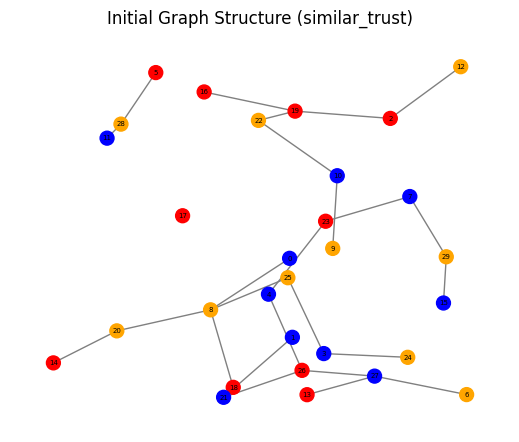

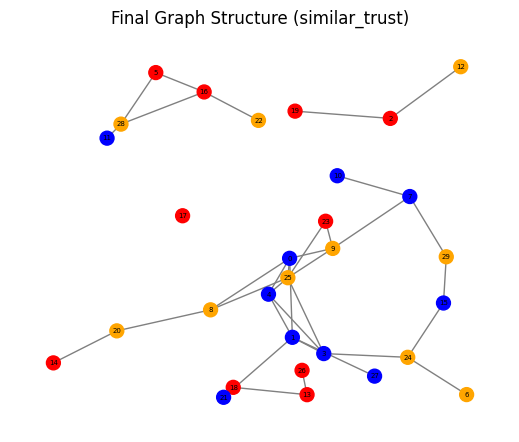

Running simulation for trust type: similar_distrust


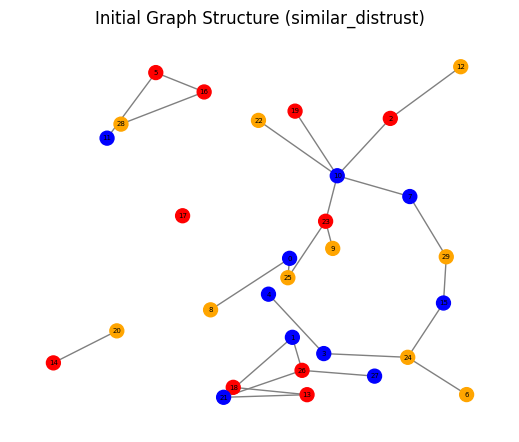

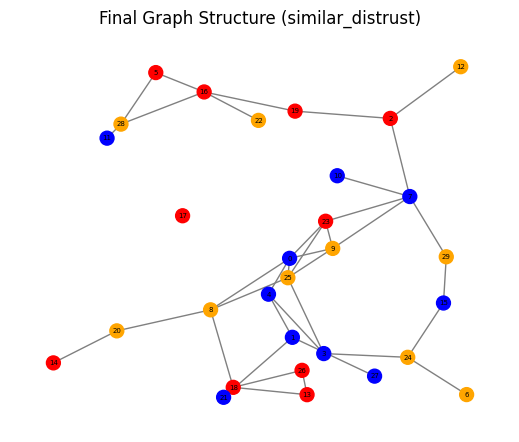

Running simulation for trust type: random


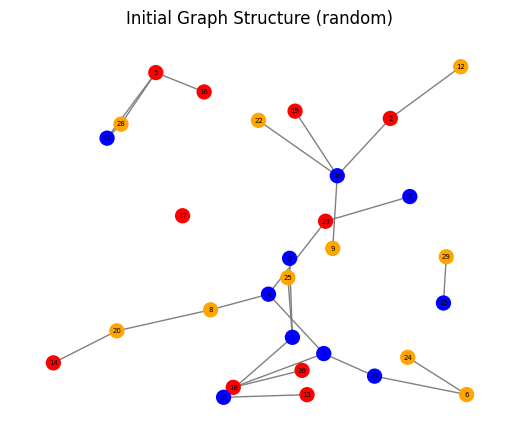

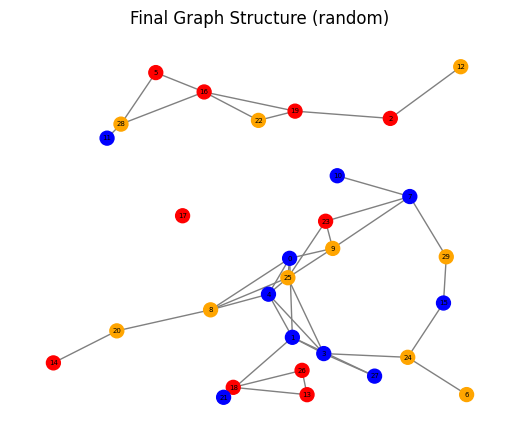

In [ ]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

random.seed(10)

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    """
    Generate fixed positions for agents.
    """
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# Function to generate fixed strengths
def generate_fixed_strengths(num_agencies):
    """
    Generate fixed strengths for agents to ensure consistency across trust settings.
    """
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths

# AgencyNetworkModel class
class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold=0.5, trust_type="similar_trust", fixed_positions=None, fixed_strengths=None):
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions

        # Use fixed strengths
        for i in range(num_agencies):
            social = fixed_strengths[i]["social"]
            tech = fixed_strengths[i]["tech"]
            human = fixed_strengths[i]["human"]
            organizational = fixed_strengths[i]["organizational"]
            strength = fixed_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def compute_benefit(self, i, j):
        """
        Compute the benefit of connecting two agencies based on trust type.
        """
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]

        if self.trust_type == "similar_trust":
            trust = -0.6 * (strength_i - strength_j) ** 2 + 0.2
        elif self.trust_type == "similar_distrust":
            trust = 0.6 * (strength_i + strength_j) ** 2 + 0.2
        elif self.trust_type == "random":
            trust = random.uniform(0, 1)

        # Ensure trust is within valid range
        trust = max(0, min(trust, 1))

        similarity = 1 - abs(strength_i - strength_j)
        alpha, beta = 0.7, 0.3
        benefit = alpha * similarity + beta * trust
        return trust, benefit

    def initialize_random_connections(self):
        """
        Create initial random connections between nearby nodes.
        """
        for i in self.graph.nodes:
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j and self.compute_distance(i, j) <= self.distance_threshold
            ]
            if potential_nodes:
                j = random.choice(potential_nodes)
                trust, benefit = self.compute_benefit(i, j)
                self.graph.add_edge(i, j, trust=trust, benefit=benefit)

    def step(self):
        """
        Simulate one step of the model.
        Agencies adjust their connections to maximize benefit.
        """
        for i in self.graph.nodes:
            neighbors = list(self.graph.neighbors(i))
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j
                and self.compute_distance(i, j) <= self.distance_threshold
                and j not in neighbors
            ]
            for j in potential_nodes:
                trust, benefit = self.compute_benefit(i, j)
                if neighbors:
                    weakest_neighbor = min(neighbors, key=lambda n: self.graph[i][n]["benefit"])
                    weakest_benefit = self.graph[i][weakest_neighbor]["benefit"]
                    if benefit > weakest_benefit:
                        self.graph.remove_edge(i, weakest_neighbor)
                        self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                        break
                else:
                    self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                    break

    def visualize_graph(self, title="Graph Structure"):
        """
        Visualize the graph structure using NetworkX.
        Nodes are colored based on their strength levels.
        """
        plt.figure(figsize=(5, 4))

        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        node_colors = []
        for i in self.graph.nodes:
            strength = self.graph.nodes[i]["strength"]
            if strength <= low_threshold:
                node_colors.append("blue")
            elif strength <= high_threshold:
                node_colors.append("orange")
            else:
                node_colors.append("red")

        pos = self.fixed_positions
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=100,
            node_color=node_colors,
            edge_color="gray",
            font_size=5,
        )
        plt.title(title)
        plt.show()


# Main Execution
if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.25
    max_iterations = 50
    trust_types = ["similar_trust", "similar_distrust", "random"]

    # Generate fixed positions and strengths
    fixed_positions = generate_fixed_positions(num_agencies)
    fixed_strengths = generate_fixed_strengths(num_agencies)

    for trust_type in trust_types:
        print(f"Running simulation for trust type: {trust_type}")
        model = AgencyNetworkModel(
            num_agencies=num_agencies,
            distance_threshold=distance_threshold,
            trust_type=trust_type,
            fixed_positions=fixed_positions,
            fixed_strengths=fixed_strengths,
        )
        model.initialize_random_connections()
        model.visualize_graph(f"Initial Graph Structure ({trust_type})")
        for iteration in range(max_iterations):
            model.step()

        # Visualize the graph
        model.visualize_graph(f"Final Graph Structure ({trust_type})")


Running simulation for trust type: similar_trust


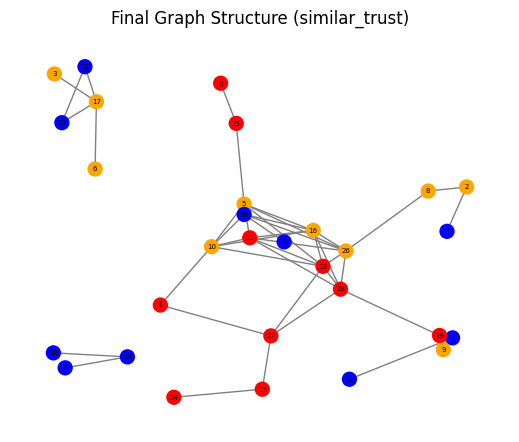

Running simulation for trust type: similar_distrust


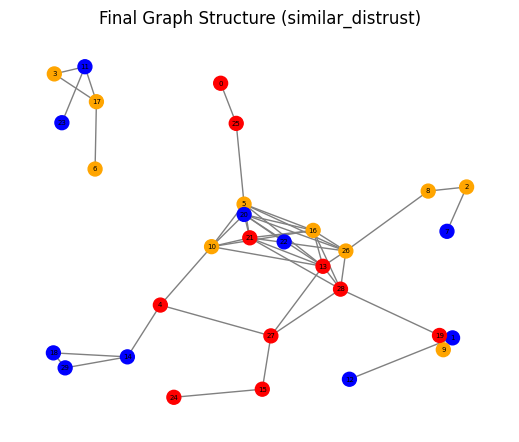

Running simulation for trust type: random


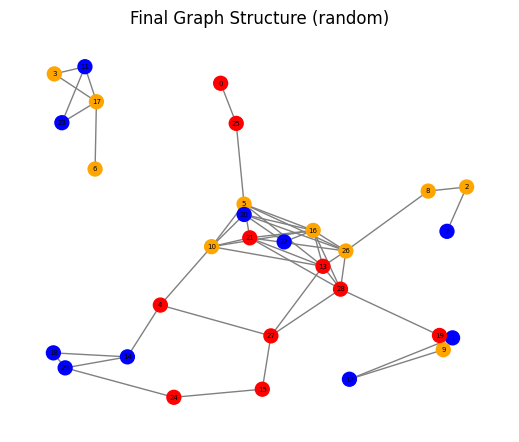


Total Benefits for Each Trust Type:
similar_trust: 31.4757
similar_distrust: 42.9363
random: 38.4780


In [ ]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

random.seed(25)

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# Function to generate fixed strengths
def generate_fixed_strengths(num_agencies):
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths

# AgencyNetworkModel class
class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold=0.5, trust_type="similar_trust", fixed_positions=None, fixed_strengths=None):
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions

        for i in range(num_agencies):
            social = fixed_strengths[i]["social"]
            tech = fixed_strengths[i]["tech"]
            human = fixed_strengths[i]["human"]
            organizational = fixed_strengths[i]["organizational"]
            strength = fixed_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def compute_benefit(self, i, j):
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]

        if self.trust_type == "similar_trust":
            trust = -0.6 * (strength_i - strength_j) ** 2 + 0.2
        elif self.trust_type == "similar_distrust":
            trust = 0.6 * (strength_i + strength_j) ** 2 + 0.2
        elif self.trust_type == "random":
            trust = random.uniform(0, 1)/2

        trust = max(0, min(trust, 1))
        similarity = 1 - abs(strength_i - strength_j)
        alpha, beta = 0.7, 0.3
        benefit = alpha * similarity + beta * trust
        return trust, benefit

    def initialize_random_connections(self):
        for i in self.graph.nodes:
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j and self.compute_distance(i, j) <= self.distance_threshold
            ]
            if potential_nodes:
                j = random.choice(potential_nodes)
                trust, benefit = self.compute_benefit(i, j)
                self.graph.add_edge(i, j, trust=trust, benefit=benefit)

    def step(self):
        for i in self.graph.nodes:
            neighbors = list(self.graph.neighbors(i))
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j
                and self.compute_distance(i, j) <= self.distance_threshold
                and j not in neighbors
            ]
            for j in potential_nodes:
                trust, benefit = self.compute_benefit(i, j)
                if neighbors:
                    weakest_neighbor = min(neighbors, key=lambda n: self.graph[i][n]["benefit"])
                    weakest_benefit = self.graph[i][weakest_neighbor]["benefit"]
                    if benefit > weakest_benefit:
                        self.graph.remove_edge(i, weakest_neighbor)
                        self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                        break
                else:
                    self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                    break

    def calculate_total_benefit(self):
        """
        Calculate the total benefit of all edges in the graph.
        """
        total_benefit = sum(self.graph[i][j]["benefit"] for i, j in self.graph.edges)
        return total_benefit

    def visualize_graph(self, title="Graph Structure"):
        plt.figure(figsize=(5, 4))

        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        node_colors = []
        for i in self.graph.nodes:
            strength = self.graph.nodes[i]["strength"]
            if strength <= low_threshold:
                node_colors.append("blue")
            elif strength <= high_threshold:
                node_colors.append("orange")
            else:
                node_colors.append("red")

        pos = self.fixed_positions
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=100,
            node_color=node_colors,
            edge_color="gray",
            font_size=5,
        )
        plt.title(title)
        plt.show()


# Main Execution
# Main Execution
if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.25
    max_iterations = 50
    trust_types = ["similar_trust", "similar_distrust", "random"]

    # Generate fixed positions and strengths
    fixed_positions = generate_fixed_positions(num_agencies)
    fixed_strengths = generate_fixed_strengths(num_agencies)

    total_benefits = {}

    for trust_type in trust_types:
        print(f"Running simulation for trust type: {trust_type}")
        model = AgencyNetworkModel(
            num_agencies=num_agencies,
            distance_threshold=distance_threshold,
            trust_type=trust_type,
            fixed_positions=fixed_positions,
            fixed_strengths=fixed_strengths,
        )
        model.initialize_random_connections()
        for iteration in range(max_iterations):
            model.step()

        # Calculate and store total benefit
        total_benefit = model.calculate_total_benefit()
        total_benefits[trust_type] = total_benefit

        # Visualize the graph
        model.visualize_graph(f"Final Graph Structure ({trust_type})")

    # Display results
    print("\nTotal Benefits for Each Trust Type:")
    for trust_type, total_benefit in total_benefits.items():
        print(f"{trust_type}: {total_benefit:.4f}")


Running simulation for trust type: similar_trust


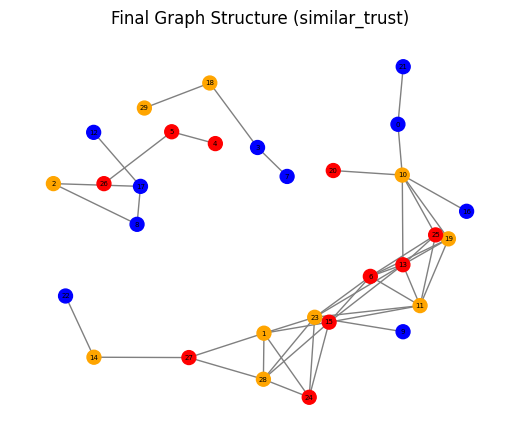

Running simulation for trust type: similar_distrust


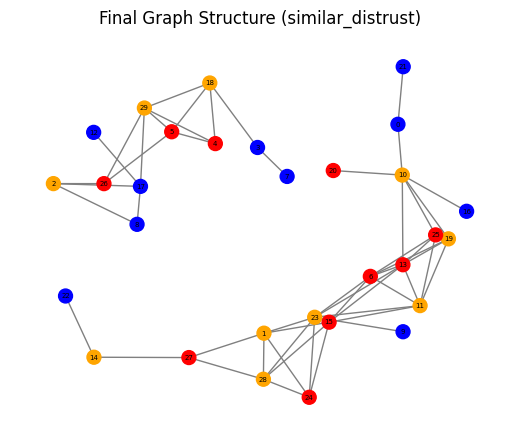

Running simulation for trust type: random


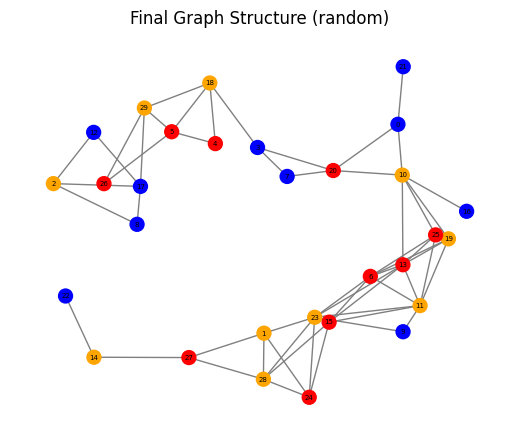


Results for Each Trust Type:

similar_trust:
  Total Benefit: 32.9525
  Mean Benefit (Low nodes): 0.6690
  Mean Benefit (Medium nodes): 0.7449
  Mean Benefit (High nodes): 0.7028

similar_distrust:
  Total Benefit: 43.3884
  Mean Benefit (Low nodes): 0.6789
  Mean Benefit (Medium nodes): 0.8359
  Mean Benefit (High nodes): 0.8397

random:
  Total Benefit: 49.8874
  Mean Benefit (Low nodes): 0.8444
  Mean Benefit (Medium nodes): 0.9279
  Mean Benefit (High nodes): 0.9074


In [ ]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

random.seed(6)

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# Function to generate fixed strengths
def generate_fixed_strengths(num_agencies):
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths

# AgencyNetworkModel class
class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold=0.5, trust_type="similar_trust", fixed_positions=None, fixed_strengths=None):
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions

        for i in range(num_agencies):
            social = fixed_strengths[i]["social"]
            tech = fixed_strengths[i]["tech"]
            human = fixed_strengths[i]["human"]
            organizational = fixed_strengths[i]["organizational"]
            strength = fixed_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def compute_benefit(self, i, j):
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]

        if self.trust_type == "similar_trust":
            trust = -0.6 * (strength_i - strength_j) ** 2 + 0.2
        elif self.trust_type == "similar_distrust":
            trust = 0.6 * (strength_i + strength_j) ** 2 - 0.2
        elif self.trust_type == "random":
            trust = random.uniform(0, 1)

        trust = max(0, min(trust, 1))
        similarity = 1 - abs(strength_i - strength_j)
        alpha, beta = 0.7, 0.3
        benefit = alpha * similarity + beta * trust
        return trust, benefit

    def initialize_random_connections(self):
        for i in self.graph.nodes:
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j and self.compute_distance(i, j) <= self.distance_threshold
            ]
            if potential_nodes:
                j = random.choice(potential_nodes)
                trust, benefit = self.compute_benefit(i, j)
                self.graph.add_edge(i, j, trust=trust, benefit=benefit)

    def step(self):
        for i in self.graph.nodes:
            neighbors = list(self.graph.neighbors(i))
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j
                and self.compute_distance(i, j) <= self.distance_threshold
                and j not in neighbors
            ]
            for j in potential_nodes:
                trust, benefit = self.compute_benefit(i, j)
                if neighbors:
                    weakest_neighbor = min(neighbors, key=lambda n: self.graph[i][n]["benefit"])
                    weakest_benefit = self.graph[i][weakest_neighbor]["benefit"]
                    if benefit > weakest_benefit:
                        self.graph.remove_edge(i, weakest_neighbor)
                        self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                        break
                else:
                    self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                    break

    def calculate_mean_benefits(self):
        """
        Calculate mean benefits for Low, Medium, and High-strength nodes.
        """
        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        type_benefits = {"Low": [], "Medium": [], "High": []}

        for i, j in self.graph.edges:
            strength_i = self.graph.nodes[i]["strength"]
            strength_j = self.graph.nodes[j]["strength"]

            benefit = self.graph[i][j]["benefit"]

            if strength_i <= low_threshold or strength_j <= low_threshold:
                type_benefits["Low"].append(benefit)
            elif strength_i > high_threshold or strength_j > high_threshold:
                type_benefits["High"].append(benefit)
            else:
                type_benefits["Medium"].append(benefit)

        mean_benefits = {
            key: np.mean(values) if values else 0 for key, values in type_benefits.items()
        }
        return mean_benefits

    def visualize_graph(self, title="Graph Structure"):
        plt.figure(figsize=(5, 4))

        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        node_colors = []
        for i in self.graph.nodes:
            strength = self.graph.nodes[i]["strength"]
            if strength <= low_threshold:
                node_colors.append("blue")
            elif strength <= high_threshold:
                node_colors.append("orange")
            else:
                node_colors.append("red")

        pos = self.fixed_positions
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=100,
            node_color=node_colors,
            edge_color="gray",
            font_size=5,
        )
        plt.title(title)
        plt.show()
# Main Execution
# Main Execution
# Main Execution
# Main Execution
if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.25
    max_iterations = 50
    trust_types = ["similar_trust", "similar_distrust", "random"]

    # Generate fixed positions and strengths
    fixed_positions = generate_fixed_positions(num_agencies)
    fixed_strengths = generate_fixed_strengths(num_agencies)

    results = {}

    for trust_type in trust_types:
        print(f"Running simulation for trust type: {trust_type}")
        model = AgencyNetworkModel(
            num_agencies=num_agencies,
            distance_threshold=distance_threshold,
            trust_type=trust_type,
            fixed_positions=fixed_positions,
            fixed_strengths=fixed_strengths,
        )

        # Visualize the initial blank graph
        #model.visualize_graph(f"Initial Graph Structure ({trust_type})")

        # Run the simulation
        for iteration in range(max_iterations):
            model.step()

        # Visualize the final optimized graph
        model.visualize_graph(f"Final Graph Structure ({trust_type})")

        # Calculate total benefit
        total_benefit = sum(model.graph[i][j]["benefit"] for i, j in model.graph.edges)

        # Calculate mean benefits for Low, Medium, and High nodes
        mean_benefits = model.calculate_mean_benefits()
        results[trust_type] = {"total_benefit": total_benefit, "mean_benefits": mean_benefits}

    # Display results
    print("\nResults for Each Trust Type:")
    for trust_type, metrics in results.items():
        print(f"\n{trust_type}:")
        print(f"  Total Benefit: {metrics['total_benefit']:.4f}")
        for node_type, mean_benefit in metrics["mean_benefits"].items():
            print(f"  Mean Benefit ({node_type} nodes): {mean_benefit:.4f}")



In [ ]:
import numpy as np
import random
import networkx as nx
from math import sqrt

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# Function to generate fixed strengths
def generate_fixed_strengths(num_agencies):
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths

# AgencyNetworkModel class
class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold=0.5, trust_type="similar_trust", fixed_positions=None, fixed_strengths=None):
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions

        for i in range(num_agencies):
            social = fixed_strengths[i]["social"]
            tech = fixed_strengths[i]["tech"]
            human = fixed_strengths[i]["human"]
            organizational = fixed_strengths[i]["organizational"]
            strength = fixed_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def compute_benefit(self, i, j):
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]

        if self.trust_type == "similar_distrust":
            trust = -0.6 * (strength_i - strength_j) ** 2 + 0.2
        elif self.trust_type == "similar_trust":
            trust = 0.6 * (strength_i + strength_j) ** 2 - 0.2
        elif self.trust_type == "random":
            trust = random.uniform(0, 1)

        trust = max(0, min(trust, 1))
        similarity = 1 - abs(strength_i - strength_j)
        alpha, beta = 0.7, 0.3
        benefit = alpha * similarity + beta * trust
        return trust, benefit

    def step(self):
        for i in self.graph.nodes:
            neighbors = list(self.graph.neighbors(i))
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j
                and self.compute_distance(i, j) <= self.distance_threshold
                and j not in neighbors
            ]
            for j in potential_nodes:
                trust, benefit = self.compute_benefit(i, j)
                if neighbors:
                    weakest_neighbor = min(neighbors, key=lambda n: self.graph[i][n]["benefit"])
                    weakest_benefit = self.graph[i][weakest_neighbor]["benefit"]
                    if benefit > weakest_benefit:
                        self.graph.remove_edge(i, weakest_neighbor)
                        self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                        break
                else:
                    self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                    break

    def calculate_mean_benefits(self):
        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        type_benefits = {"Low": [], "Medium": [], "High": []}

        for i, j in self.graph.edges:
            strength_i = self.graph.nodes[i]["strength"]
            strength_j = self.graph.nodes[j]["strength"]

            benefit = self.graph[i][j]["benefit"]

            if strength_i <= low_threshold or strength_j <= low_threshold:
                type_benefits["Low"].append(benefit)
            elif strength_i > high_threshold or strength_j > high_threshold:
                type_benefits["High"].append(benefit)
            else:
                type_benefits["Medium"].append(benefit)

        mean_benefits = {
            key: np.mean(values) if values else 0 for key, values in type_benefits.items()
        }
        return mean_benefits

# Main Execution
if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.25
    max_iterations = 50
    trust_types = ["similar_trust", "similar_distrust", "random"]
    num_simulations = 100

    # Results dictionary to store aggregated results
    aggregated_results = {trust_type: {"total_benefit": [], "mean_benefits": {"Low": [], "Medium": [], "High": []}}
                          for trust_type in trust_types}

    for sim in range(num_simulations):
        # Generate fixed positions and strengths for each simulation
        fixed_positions = generate_fixed_positions(num_agencies)
        fixed_strengths = generate_fixed_strengths(num_agencies)

        for trust_type in trust_types:
            model = AgencyNetworkModel(
                num_agencies=num_agencies,
                distance_threshold=distance_threshold,
                trust_type=trust_type,
                fixed_positions=fixed_positions,
                fixed_strengths=fixed_strengths,
            )

            for iteration in range(max_iterations):
                model.step()

            # Calculate total benefit
            total_benefit = sum(model.graph[i][j]["benefit"] for i, j in model.graph.edges)
            aggregated_results[trust_type]["total_benefit"].append(total_benefit)

            # Calculate mean benefits for node groups
            mean_benefits = model.calculate_mean_benefits()
            for group in ["Low", "Medium", "High"]:
                aggregated_results[trust_type]["mean_benefits"][group].append(mean_benefits[group])

    # Compute averages
    for trust_type in trust_types:
        avg_total_benefit = np.mean(aggregated_results[trust_type]["total_benefit"])
        avg_mean_benefits = {group: np.mean(aggregated_results[trust_type]["mean_benefits"][group])
                             for group in ["Low", "Medium", "High"]}
        print(f"\nTrust Type: {trust_type}")
        print(f"  Average Total Benefit: {avg_total_benefit:.4f}")
        for group, avg_benefit in avg_mean_benefits.items():
            print(f"  Average Mean Benefit ({group} nodes): {avg_benefit:.4f}")



Trust Type: similar_trust
  Average Total Benefit: 35.0321
  Average Mean Benefit (Low nodes): 0.6861
  Average Mean Benefit (Medium nodes): 0.7911
  Average Mean Benefit (High nodes): 0.8178

Trust Type: similar_distrust
  Average Total Benefit: 28.0782
  Average Mean Benefit (Low nodes): 0.6771
  Average Mean Benefit (Medium nodes): 0.7288
  Average Mean Benefit (High nodes): 0.6910

Trust Type: random
  Average Total Benefit: 41.0420
  Average Mean Benefit (Low nodes): 0.8771
  Average Mean Benefit (Medium nodes): 0.9251
  Average Mean Benefit (High nodes): 0.8918


Running simulation for trust type: similar_trust
Running simulation for trust type: similar_distrust
Running simulation for trust type: random


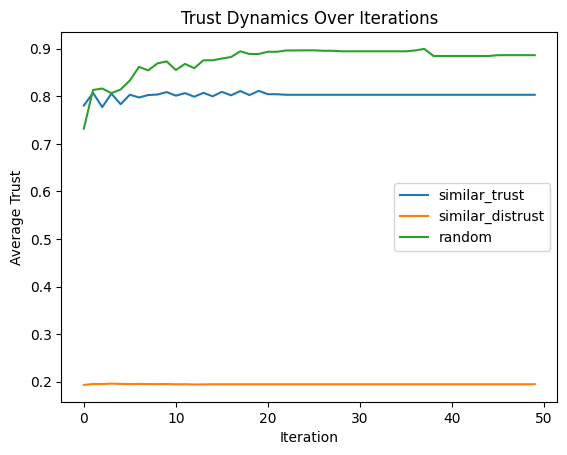

In [ ]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

random.seed(42)

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# Function to generate fixed strengths
def generate_fixed_strengths(num_agencies):
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths

# AgencyNetworkModel class
class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold=0.5, trust_type="similar_trust", fixed_positions=None, fixed_strengths=None):
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions

        for i in range(num_agencies):
            social = fixed_strengths[i]["social"]
            tech = fixed_strengths[i]["tech"]
            human = fixed_strengths[i]["human"]
            organizational = fixed_strengths[i]["organizational"]
            strength = fixed_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def compute_benefit(self, i, j):
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]

        if self.trust_type == "similar_distrust":
            trust = -0.6 * (strength_i - strength_j) ** 2 + 0.2
        elif self.trust_type == "similar_trust":
            trust = 0.6 * (strength_i + strength_j) ** 2 + 0.2
        elif self.trust_type == "random":
            trust = random.uniform(0, 1)/2

        trust = max(0, min(trust, 1))
        similarity = 1 - abs(strength_i - strength_j)
        alpha, beta = 0.7, 0.3
        benefit = alpha * similarity + beta * trust
        return trust, benefit

    def initialize_random_connections(self):
        for i in self.graph.nodes:
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j and self.compute_distance(i, j) <= self.distance_threshold
            ]
            if potential_nodes:
                j = random.choice(potential_nodes)
                trust, benefit = self.compute_benefit(i, j)
                self.graph.add_edge(i, j, trust=trust, benefit=benefit)

    def step(self):
        for i in self.graph.nodes:
            neighbors = list(self.graph.neighbors(i))
            potential_nodes = [
                j for j in self.graph.nodes
                if i != j
                and self.compute_distance(i, j) <= self.distance_threshold
                and j not in neighbors
            ]
            for j in potential_nodes:
                trust, benefit = self.compute_benefit(i, j)
                if neighbors:
                    weakest_neighbor = min(neighbors, key=lambda n: self.graph[i][n]["benefit"])
                    weakest_benefit = self.graph[i][weakest_neighbor]["benefit"]
                    if benefit > weakest_benefit:
                        self.graph.remove_edge(i, weakest_neighbor)
                        self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                        break
                else:
                    self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                    break

    def analyze_edge_trust(self):
        edge_trust_values = [self.graph[i][j]["trust"] for i, j in self.graph.edges]
        avg_edge_trust = np.mean(edge_trust_values) if edge_trust_values else 0
        return edge_trust_values, avg_edge_trust

    def analyze_trust_homophily(self):
        trust_differences = []
        for i, j in self.graph.edges:
            trust_i = self.graph.nodes[i]["strength"]
            trust_j = self.graph.nodes[j]["strength"]
            trust_differences.append(abs(trust_i - trust_j))
        avg_trust_diff = np.mean(trust_differences) if trust_differences else 0
        return avg_trust_diff

    def track_trust_over_iterations(self, max_iterations):
        trust_dynamics = []
        for _ in range(max_iterations):
            self.step()
            _, avg_trust = self.analyze_edge_trust()
            trust_dynamics.append(avg_trust)
        return trust_dynamics

    def visualize_graph(self, title="Graph Structure"):
        plt.figure(figsize=(6, 5))
        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        node_colors = []
        for i in self.graph.nodes:
            strength = self.graph.nodes[i]["strength"]
            if strength <= low_threshold:
                node_colors.append("blue")
            elif strength <= high_threshold:
                node_colors.append("orange")
            else:
                node_colors.append("red")

        pos = self.fixed_positions
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=100,
            node_color=node_colors,
            edge_color="gray",
            font_size=5,
        )
        plt.title(title)
        plt.show()

# Main Execution
if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.25
    max_iterations = 50
    trust_types = ["similar_trust", "similar_distrust", "random"]

    fixed_positions = generate_fixed_positions(num_agencies)
    fixed_strengths = generate_fixed_strengths(num_agencies)

    for trust_type in trust_types:
        print(f"Running simulation for trust type: {trust_type}")
        model = AgencyNetworkModel(
            num_agencies=num_agencies,
            distance_threshold=distance_threshold,
            trust_type=trust_type,
            fixed_positions=fixed_positions,
            fixed_strengths=fixed_strengths,
        )
        model.initialize_random_connections()

        trust_dynamics = model.track_trust_over_iterations(max_iterations)
        plt.plot(trust_dynamics, label=trust_type)

    plt.xlabel("Iteration")
    plt.ylabel("Average Trust")
    plt.title("Trust Dynamics Over Iterations")
    plt.legend()
    plt.show()


Running simulation for trust type: similar_trust


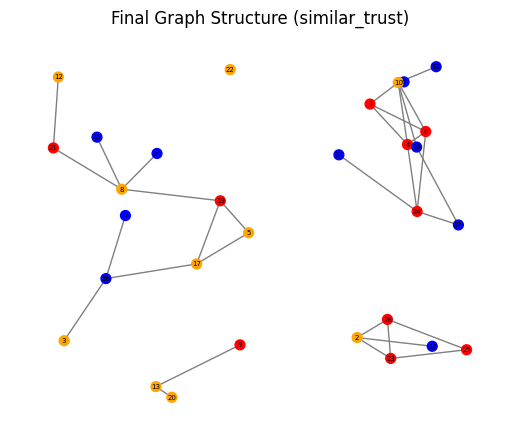

Running simulation for trust type: similar_distrust


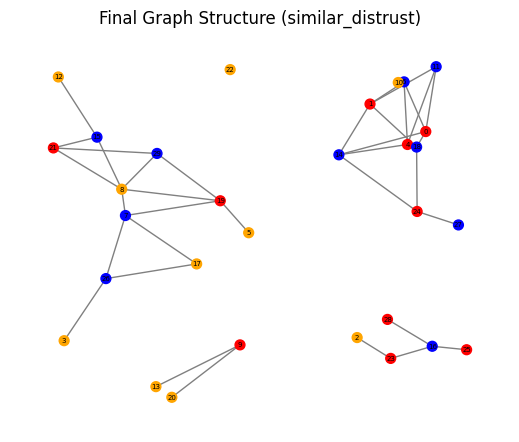

Running simulation for trust type: random


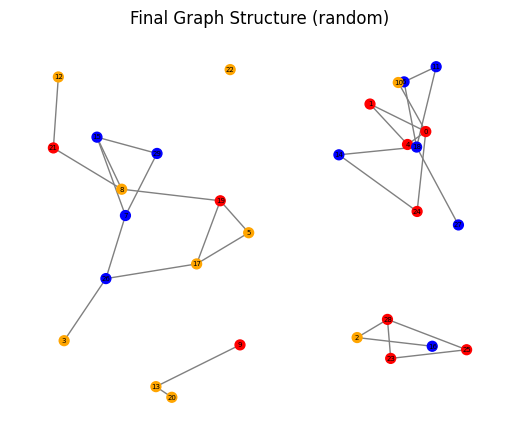

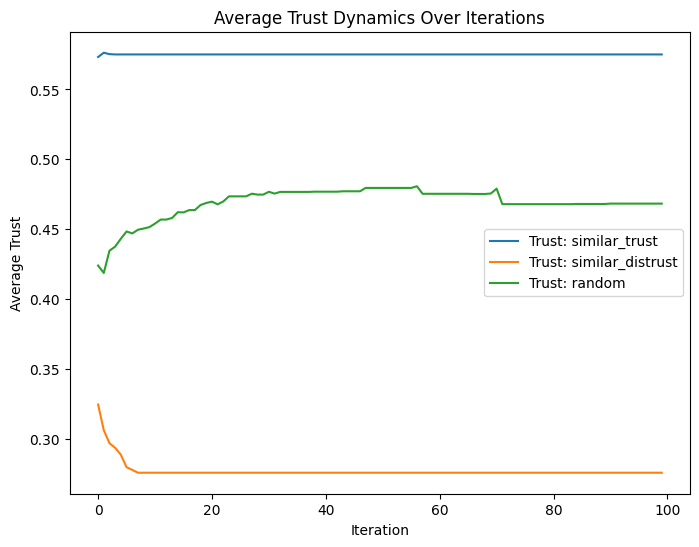

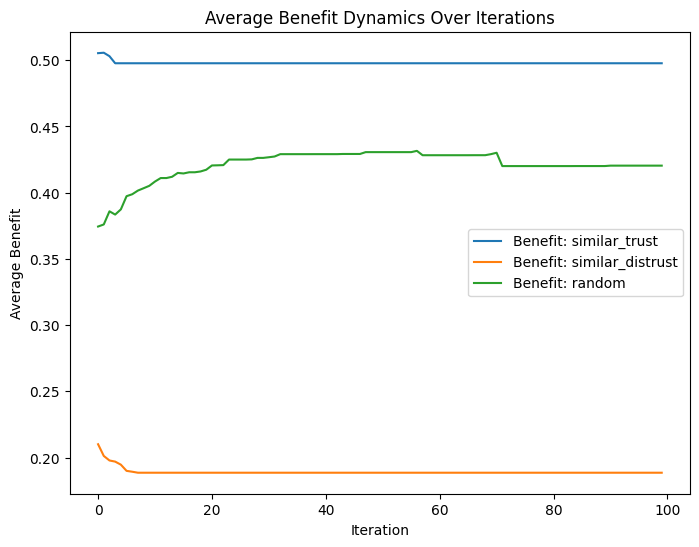

In [ ]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

#random.seed(42)

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# Function to generate fixed strengths
def generate_fixed_strengths(num_agencies):
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths


class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold, trust_type, fixed_positions=None, fixed_strengths=None):
        """
        Initialize the model with a blank graph and predefined strengths and positions.
        """
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions

        # Add nodes with predefined strengths
        for i in range(num_agencies):
            social = fixed_strengths[i]["social"]
            tech = fixed_strengths[i]["tech"]
            human = fixed_strengths[i]["human"]
            organizational = fixed_strengths[i]["organizational"]
            strength = fixed_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        """
        Compute the Euclidean distance between nodes i and j using fixed positions.
        """
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def find_neighbors_within_threshold(self, i):
        """
        Find all nodes within the distance threshold of node i (including those without edges).
        """
        neighbors = [
            j for j in self.graph.nodes
            if i != j and self.compute_distance(i, j) <= self.distance_threshold
        ]
        return neighbors
    def calculate_average_trust(self):
        """
        Calculate the average trust across all edges in the graph.
        """
        if self.graph.number_of_edges() == 0:
            return 0  # Avoid division by zero
        return np.mean([self.graph[i][j]["trust"] for i, j in self.graph.edges])

    def calculate_average_benefit(self):
        """
        Calculate the average benefit across all edges in the graph.
        """
        if self.graph.number_of_edges() == 0:
            return 0  # Avoid division by zero
        return np.mean([self.graph[i][j]["benefit"] for i, j in self.graph.edges])




    def compute_benefit(self, i, j):
        """
        Compute the benefit of connecting two agencies based on the trust function.
        """
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]
        a=1
        b=0
        if self.trust_type == "similar_distrust":
            #trust = -a* (strength_i - strength_j) ** 2 - b
            trust = abs(strength_i - strength_j)

        elif self.trust_type == "similar_trust":
            trust = abs(strength_i + strength_j)/2

        elif self.trust_type == "random":
            trust = random.uniform(0, 1)/2

        #trust = max(0, min(trust, 1))
        similarity = 1 - abs(strength_i - strength_j)
        alpha, beta = 0.7, 0.3
        #benefit = alpha * similarity + beta * trust
        benefit = similarity * trust
        return trust, benefit

    def step(self):
      """
      Simulate one step of the model.
      Agencies adjust their connections to maximize benefit, constrained to 5 arcs per node.
      """
      for i in self.graph.nodes:
          # Skip if the node already has 5 arcs
          if self.graph.degree[i] >= 5:
              continue

          # Find all neighbors within the distance threshold
          neighbors_within_threshold = self.find_neighbors_within_threshold(i)

          # Filter out nodes already connected
          potential_nodes = [j for j in neighbors_within_threshold if not self.graph.has_edge(i, j)]

          # Evaluate new connections
          for j in potential_nodes:
              trust, benefit = self.compute_benefit(i, j)

              if self.graph.degree[i] > 0:  # If the node already has connections
                  weakest_neighbor = min(self.graph.neighbors(i), key=lambda n: self.graph[i][n]["benefit"])
                  weakest_benefit = self.graph[i][weakest_neighbor]["benefit"]

                  if benefit > weakest_benefit:
                      # Remove the weakest connection and add the new one if under the arc limit
                      self.graph.remove_edge(i, weakest_neighbor)
                      self.graph.add_edge(i, j, trust=trust, benefit=benefit)

                      # Check if the maximum arc limit has been reached
                      if self.graph.degree[i] >= 5:
                          break
              else:  # No existing connections
                  self.graph.add_edge(i, j, trust=trust, benefit=benefit)

                  # Stop adding new connections if the maximum arc limit is reached
                  if self.graph.degree[i] >= 5:
                      break
    from community import community_louvain  # For clustering
    import matplotlib.colors as mcolors

    def visualize_graph_with_clusters(self, title="Graph Structure with Clusters"):
        """
        Visualize the graph with color coding for clusters and strength.
        """
        plt.figure(figsize=(6, 5))

        # Detect clusters using the Louvain method
        partition = community_louvain.best_partition(self.graph)
        unique_clusters = set(partition.values())

        # Generate unique colors for each cluster
        cluster_colors = list(mcolors.TABLEAU_COLORS.keys())[:len(unique_clusters)]

        # Map nodes to cluster colors
        cluster_color_map = {cluster: color for cluster, color in zip(unique_clusters, cluster_colors)}

        # Map nodes to strength thresholds
        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        node_colors = []
        for i in self.graph.nodes:
            strength = self.graph.nodes[i]["strength"]
            cluster = partition[i]
            cluster_color = cluster_color_map[cluster]

            # Combine cluster color with strength (e.g., border effect)
            if strength <= low_threshold:
                node_colors.append((cluster_color, "blue"))  # Cluster color with low strength
            elif strength <= high_threshold:
                node_colors.append((cluster_color, "orange"))  # Cluster color with medium strength
            else:
                node_colors.append((cluster_color, "red"))  # Cluster color with high strength

        # Prepare cluster and node visuals
        pos = self.fixed_positions
        cluster_color_only = [c for c, _ in node_colors]

        # Draw nodes with cluster colors
        nx.draw_networkx_nodes(
            self.graph,
            pos,
            node_color=cluster_color_only,
            node_size=100,
        )

        # Draw edges
        nx.draw_networkx_edges(self.graph, pos, alpha=0.5, edge_color="gray")

        # Draw node labels
        nx.draw_networkx_labels(self.graph, pos, font_size=5)

        plt.title(title)
        plt.show()


    def visualize_graph(self, title="Graph Structure"):
        """
        Visualize the graph structure using NetworkX.
        """
        plt.figure(figsize=(5, 4))
        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        node_colors = []
        for i in self.graph.nodes:
            strength = self.graph.nodes[i]["strength"]
            if strength <= low_threshold:
                node_colors.append("blue")
            elif strength <= high_threshold:
                node_colors.append("orange")
            else:
                node_colors.append("red")

        pos = self.fixed_positions
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=50,
            node_color=node_colors,
            edge_color="gray",
            font_size=5,
        )
        plt.title(title)
        plt.show()
if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.25
    max_iterations = 100
    trust_types = ["similar_trust", "similar_distrust", "random"]

    fixed_positions = generate_fixed_positions(num_agencies)
    fixed_strengths = generate_fixed_strengths(num_agencies)

    trust_dynamics = {trust_type: [] for trust_type in trust_types}
    benefit_dynamics = {trust_type: [] for trust_type in trust_types}

    for trust_type in trust_types:
        print(f"Running simulation for trust type: {trust_type}")
        distance_threshold = 0.25
        model = AgencyNetworkModel(
            num_agencies=num_agencies,
            distance_threshold=distance_threshold,
            trust_type=trust_type,
            fixed_positions=fixed_positions,
            fixed_strengths=fixed_strengths,
        )

        # Initial blank graph (optional visualization)
        #model.visualize_graph(f"Initial Blank Graph ({trust_type})")

        # Track average trust and benefit over iterations
        for iteration in range(max_iterations):
            model.step()
            avg_trust = model.calculate_average_trust()
            avg_benefit = model.calculate_average_benefit()
            trust_dynamics[trust_type].append(avg_trust)
            benefit_dynamics[trust_type].append(avg_benefit)

        # Final graph visualization (optional)
        model.visualize_graph(f"Final Graph Structure ({trust_type})")

    # Plot average trust over iterations
    plt.figure(figsize=(8, 6))
    for trust_type in trust_types:
        plt.plot(trust_dynamics[trust_type], label=f"Trust: {trust_type}")
    plt.xlabel("Iteration")
    plt.ylabel("Average Trust")
    plt.title("Average Trust Dynamics Over Iterations")
    plt.legend()
    plt.show()

    # Plot average benefit over iterations
    plt.figure(figsize=(8, 6))
    for trust_type in trust_types:
        plt.plot(benefit_dynamics[trust_type], label=f"Benefit: {trust_type}")
    plt.xlabel("Iteration")
    plt.ylabel("Average Benefit")
    plt.title("Average Benefit Dynamics Over Iterations")
    plt.legend()
    plt.show()


In [ ]:
from matplotlib import colors as mcolors


In [ ]:
def compute_T(s_i, s_j, B=0.5, W=0.4, D=0.3, S=0.2):
    trust = (1 - abs(s_i - s_j)) + (1 - (s_i + s_j)) / 2
    return trust

In [ ]:
compute_T(1,1)

0.5

In [ ]:
compute_T(1, 0)

0.0

Running simulation for trust type: similar_trust
Valid clusters for similar_trust: 0


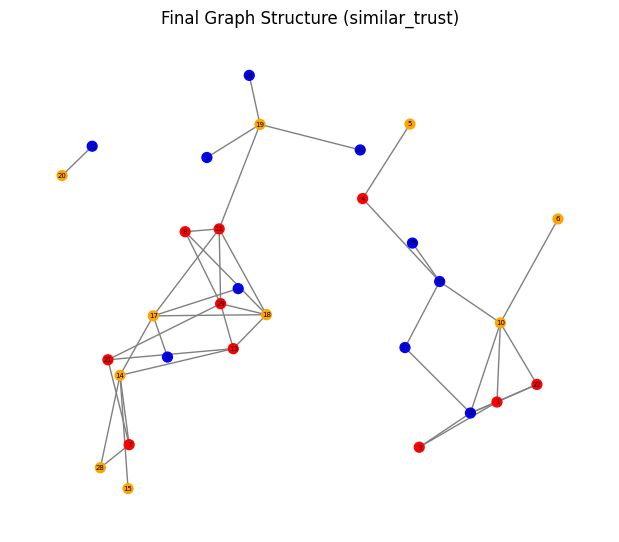

Running simulation for trust type: similar_distrust
Valid clusters for similar_distrust: 0


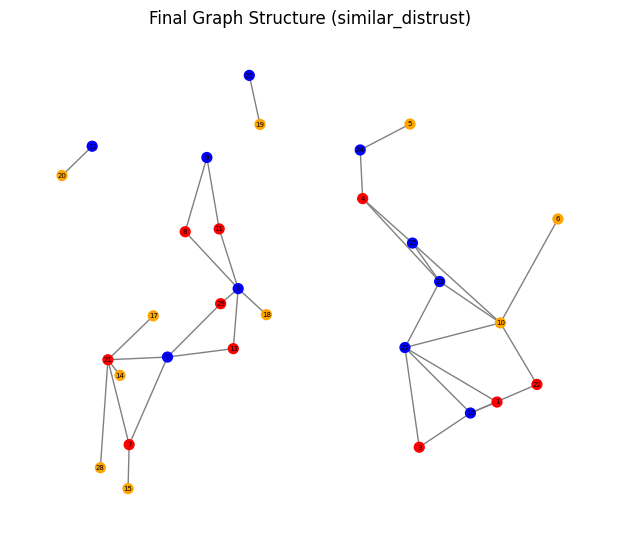

Running simulation for trust type: random
Valid clusters for random: 0


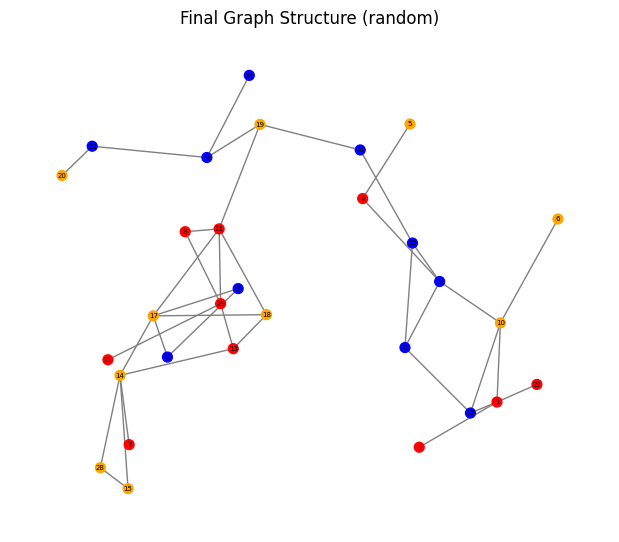

In [ ]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from math import sqrt

# Function to generate fixed positions
def generate_fixed_positions(num_agencies):
    positions = {i: (random.uniform(0, 1), random.uniform(0, 1)) for i in range(num_agencies)}
    return positions

# Function to generate fixed strengths
def generate_fixed_strengths(num_agencies):
    strengths = []
    for _ in range(num_agencies):
        social = random.uniform(0, 1)
        tech = random.uniform(0, 1)
        human = random.uniform(0, 1)
        organizational = random.uniform(0, 1)
        strength = (social + tech + human + organizational) / 4
        strengths.append({
            "social": social,
            "tech": tech,
            "human": human,
            "organizational": organizational,
            "strength": strength
        })
    return strengths

class AgencyNetworkModel:
    def __init__(self, num_agencies, distance_threshold, trust_type, fixed_positions=None, fixed_strengths=None):
        self.graph = nx.Graph()
        self.distance_threshold = distance_threshold
        self.trust_type = trust_type
        self.fixed_positions = fixed_positions

        for i in range(num_agencies):
            social = fixed_strengths[i]["social"]
            tech = fixed_strengths[i]["tech"]
            human = fixed_strengths[i]["human"]
            organizational = fixed_strengths[i]["organizational"]
            strength = fixed_strengths[i]["strength"]

            self.graph.add_node(
                i,
                social=social,
                tech=tech,
                human=human,
                organizational=organizational,
                strength=strength,
            )

    def compute_distance(self, i, j):
        x1, y1 = self.fixed_positions[i]
        x2, y2 = self.fixed_positions[j]
        return sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def find_neighbors_within_threshold(self, i):
        neighbors = [
            j for j in self.graph.nodes
            if i != j and self.compute_distance(i, j) <= self.distance_threshold
        ]
        return neighbors

    def calculate_average_trust(self):
        if self.graph.number_of_edges() == 0:
            return 0
        return np.mean([self.graph[i][j]["trust"] for i, j in self.graph.edges])

    def calculate_average_benefit(self):
        if self.graph.number_of_edges() == 0:
            return 0
        return np.mean([self.graph[i][j]["benefit"] for i, j in self.graph.edges])

    def compute_heterogeneity(self, cluster):
        strengths = [self.graph.nodes[node]["strength"] for node in cluster]
        if len(strengths) > 1:  # Variance is meaningful only for 2+ nodes
            return np.var(strengths)
        return 0  # Single-node clusters have no heterogeneity

    def validate_clusters(self, heterogeneity_threshold=0.5, max_cluster_size=6):
        clusters = list(nx.connected_components(self.graph))
        valid_clusters = []

        for cluster in clusters:
            heterogeneity = self.compute_heterogeneity(cluster)
            if heterogeneity >= heterogeneity_threshold and len(cluster) <= max_cluster_size:
                valid_clusters.append(cluster)

        return valid_clusters

    def compute_benefit(self, i, j):
        node_i = self.graph.nodes[i]
        node_j = self.graph.nodes[j]

        strength_i = node_i["strength"]
        strength_j = node_j["strength"]

        if self.trust_type == "similar_distrust":
            trust = abs(strength_i - strength_j)
        elif self.trust_type == "similar_trust":
            trust = abs(strength_i + strength_j) / 2
        elif self.trust_type == "random":
            trust = random.uniform(0, 1) / 2

        similarity = 1 - abs(strength_i - strength_j)
        benefit = similarity * trust
        return trust, benefit

    def step(self):
        for i in self.graph.nodes:
            if self.graph.degree[i] >= 5:
                continue

            neighbors_within_threshold = self.find_neighbors_within_threshold(i)
            potential_nodes = [j for j in neighbors_within_threshold if not self.graph.has_edge(i, j)]

            for j in potential_nodes:
                trust, benefit = self.compute_benefit(i, j)

                if self.graph.degree[i] > 0:
                    weakest_neighbor = min(self.graph.neighbors(i), key=lambda n: self.graph[i][n]["benefit"])
                    weakest_benefit = self.graph[i][weakest_neighbor]["benefit"]

                    if benefit > weakest_benefit:
                        self.graph.remove_edge(i, weakest_neighbor)
                        self.graph.add_edge(i, j, trust=trust, benefit=benefit)

                        if self.graph.degree[i] >= 5:
                            break
                else:
                    self.graph.add_edge(i, j, trust=trust, benefit=benefit)
                    if self.graph.degree[i] >= 5:
                        break

    def visualize_graph(self, title="Graph Structure"):
        plt.figure(figsize=(6, 5))
        strengths = [self.graph.nodes[i]["strength"] for i in self.graph.nodes]
        low_threshold = np.percentile(strengths, 33)
        high_threshold = np.percentile(strengths, 66)

        node_colors = []
        for i in self.graph.nodes:
            strength = self.graph.nodes[i]["strength"]
            if strength <= low_threshold:
                node_colors.append("blue")
            elif strength <= high_threshold:
                node_colors.append("orange")
            else:
                node_colors.append("red")

        pos = self.fixed_positions
        nx.draw(
            self.graph,
            pos,
            with_labels=True,
            node_size=50,
            node_color=node_colors,
            edge_color="gray",
            font_size=5,
        )
        plt.title(title)
        plt.show()


if __name__ == "__main__":
    num_agencies = 30
    distance_threshold = 0.25
    max_iterations = 50
    trust_types = ["similar_trust", "similar_distrust", "random"]

    fixed_positions = generate_fixed_positions(num_agencies)
    fixed_strengths = generate_fixed_strengths(num_agencies)

    for trust_type in trust_types:
        print(f"Running simulation for trust type: {trust_type}")
        model = AgencyNetworkModel(
            num_agencies=num_agencies,
            distance_threshold=distance_threshold,
            trust_type=trust_type,
            fixed_positions=fixed_positions,
            fixed_strengths=fixed_strengths,
        )

        for iteration in range(max_iterations):
            model.step()

        valid_clusters = model.validate_clusters()
        print(f"Valid clusters for {trust_type}: {len(valid_clusters)}")
        model.visualize_graph(f"Final Graph Structure ({trust_type})")